In [1]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-20", end="2019-05-21")

returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
# returns.index = returns.index.tz_localize('UTC')
returns = returns.stack()
returns

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [3]:
# Volume

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [4]:
# 5 day open price predictive factor

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
# factor.index = factor.index.tz_localize('UTC')
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [5]:
# 10 day open price non-predictive factor 

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [6]:
# 10-day Momentum

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")
momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [7]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# %%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

# %%time
df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (6 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (6 days old).
- Loading from disk ... Done!


In [8]:
# Price to book value
df_pbv = pd.DataFrame()
for i in tickers:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pbv = df_pbv.stack()
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [9]:
# Market Cap
df_mc = pd.DataFrame()
for i in tickers:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [10]:
# P/E
df_pe = pd.DataFrame()
for i in tickers:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [72]:
from datetime import datetime
from tabulate import tabulate

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

#df_original = pd.DataFrame.from_dict(data)
#df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor","Momentum","Price to book Value","Market Cap"], inplace=True)
df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810748,4.168957,0.481235,-0.585197,-0.658513,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173145,-0.364517,0.269450,0.889325,0.762768,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868855,-0.175676,1.211605,-1.113785,-1.318079,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147891,-0.182383,0.935859,-0.865218,-0.668475,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070578,-0.362698,0.926078,-0.218245,-0.054706,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380690,0.981545,2.885535,-3.115083,-3.223191,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996915,-0.306641,1.326232,-1.656099,-1.652367,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220526,-0.344192,-0.781094,0.387177,0.001531,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744173,-0.125277,-0.862245,0.519055,0.443085,-0.244783,0.371986,-0.069833


In [143]:
tabulate(df_original.tail(5),headers = 'keys',tablefmt = 'latex')

'\\begin{tabular}{rllrrrrrrrr}\n\\hline\n       & Date                & Asset   &   Returns &    Volume &   Predictive Factor &   Non-Predictive Factor &    Momentum &   Price to book Value &   Market Cap &         P/E \\\\\n\\hline\n 40235 & 2019-05-20 00:00:00 & TSLA    & -1.38069  &  0.981545 &            2.88553  &               -3.11508  & -3.22319    &             -0.106688 &    -0.649447 & -0.281058   \\\\\n 40236 & 2019-05-20 00:00:00 & TXN     & -0.996915 & -0.306641 &            1.32623  &               -1.6561   & -1.65237    &              0.356096 &    -0.313561 & -0.0580447  \\\\\n 40237 & 2019-05-20 00:00:00 & V       & -0.220526 & -0.344192 &           -0.781094 &                0.387177 &  0.00153138 &              0.50291  &     1.39006  &  0.0379388  \\\\\n 40238 & 2019-05-20 00:00:00 & VZ      &  0.744173 & -0.125277 &           -0.862245 &                0.519055 &  0.443085   &             -0.244783 &     0.371986 & -0.0698332  \\\\\n 40239 & 2019-05-20 00:00:00 &

In [12]:
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==len(tickers):
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [87]:
np.array(tensor)

array([[[-8.10748492e-01,  4.16895682e+00,  4.81234908e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73145036e-01, -3.64517363e-01,  2.69449957e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68855097e-01, -1.75675935e-01,  1.21160491e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16963943e-01, -1.75317019e-01,  2.72517890e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59119418e-01, -2.64450151e-01,  2.43231469e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32721936e-01, -3.62254159e-01,  2.42414348e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54432784e-01,  4.78699168e+00,  6.93646109e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28184802e+00, -3.59660481e-01,  3.48496285e-01, ...,
         -3.42813725e-01, -7.33077090e

In [ ]:
from corcondia import corcondia_3d
c_score=[]
for i in range(1,101,1):
    c_score.append(corcondia_3d(np.array(tensor), k=i))
plt.plot([range(1,101,1),c_score])

In [95]:
c_score

[100.0,
 99.99999996752823,
 90.93157210343034,
 21.56111784113718,
 -649.6036239661344,
 -81.72479766427807,
 -11425919.941397069,
 -74287.1409135479,
 -823861.4222129293,
 -7103700.178378546,
 -14104436.165896168,
 -5787061.6262249295,
 -511271.3926546015,
 -1175554.605101421,
 -48635410.516788535,
 -413157.9635363758,
 -270469943.60275704,
 -219650459.86492267,
 -1708728.9867332405,
 -987479.7317711335]

In [15]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [145]:
alg = CPD(10)
alg

CPD(epsilon=0.01, init=10, max_iter=50, random_state=None, tol=0.0001,
    verbose=False)

In [146]:
kruskal_rank = (100,)

tensor_cpd = alg.decompose(tensor_data, rank=kruskal_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_cpd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_cpd.core)
tensor_cpd.core.data

	Output of the CPD algorithm:
Kruskal representation of a tensor with rank=(100,).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 100)
Mode-1 factor matrix is of shape (20, 100)
Mode-2 factor matrix is of shape (8, 100)

	Core tensor
This tensor is of order 3 and consists of 1000000 elements.
Sizes and names of its modes are (100, 100, 100) and ['mode-0', 'mode-1', 'mode-2'] respectively.


array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [147]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_cpd.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 100)
Mode-1 factor matrix is of shape (20, 100)
Mode-2 factor matrix is of shape (8, 100)


[array([[-0.07777122, -0.08024587,  0.17970417, ..., -0.36809905,
          0.28549366,  0.12165148],
        [-0.03603312, -0.15226601,  0.21729976, ..., -0.479547  ,
          0.15991755,  0.03595941],
        [-0.07536516, -0.10429597, -0.04506851, ..., -0.30090329,
          0.05838989, -0.14658685],
        ...,
        [ 0.2669289 , -0.63404971, -0.05535841, ..., -0.42567277,
          0.41554881, -0.08197715],
        [ 0.12192591, -0.68310713, -0.543132  , ..., -0.5210146 ,
          0.60357369, -0.19259836],
        [ 0.26446939, -0.60414014, -0.50573364, ..., -1.13862295,
          0.69395627, -0.28148442]]),
 array([[ 0.41487702,  1.42252067,  1.05209459, ...,  1.60627671,
         -1.49602686, -1.88500145],
        [ 0.29469319,  0.76839633,  0.09728781, ...,  0.12397322,
         -0.29258833, -0.51141735],
        [-1.78403926,  0.23878739,  0.3421072 , ...,  0.48382583,
         -0.56087551, -0.34668571],
        ...,
        [-0.06449586,  0.74751287,  0.19313675, ...,  

In [170]:
index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
# index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_cpd.fmat[1], columns = [i for i in range(tensor_cpd.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
AAPL,0.414877,1.422521,1.052095,-1.575813,-0.352734,0.924332,1.428916,0.574198,-0.273454,-5.621202,...,-0.198293,-0.284427,-0.745343,2.050314,-0.908128,1.246817,-3.548798,1.606277,-1.496027,-1.885001
ADBE,0.294693,0.768396,0.097288,-0.322874,0.187834,-0.021049,0.143875,-0.256604,0.939829,0.711801,...,0.641768,-0.286191,-0.273080,0.284830,0.707643,0.146057,-0.373359,0.123973,-0.292588,-0.511417
AMAT,-1.784039,0.238787,0.342107,-0.601613,-0.071976,0.713895,-1.050689,-0.664820,-1.050844,0.838274,...,0.665086,-0.711532,-0.328706,-0.235944,-0.031924,0.253996,-0.569416,0.483826,-0.560876,-0.346686
AMD,1.968670,-1.093851,0.425671,-3.468594,-0.597938,-0.044405,2.868039,-0.428029,1.960529,3.217535,...,-1.424851,-1.770756,-1.036805,-1.808955,-0.354131,-0.791007,0.987468,-0.607503,0.289879,-2.111924
AMZN,0.213899,0.937411,2.035443,-1.248202,-0.072666,-0.775651,1.490377,-1.081099,-1.189808,-2.725859,...,-0.672118,-0.873718,-0.695347,0.598971,0.435312,-0.945036,0.891029,-0.834178,-1.041968,0.191897
CSCO,1.418302,-0.188552,0.101278,-0.550735,0.735705,-0.144885,-2.100758,-0.181955,0.367041,1.405889,...,0.146711,1.981531,0.829736,-1.292132,-0.741945,0.648441,0.058544,-1.119800,0.245589,-0.518343
GOOGL,-1.598360,0.852013,0.334227,-0.097923,0.079526,0.420704,-0.208587,1.409996,-0.136165,-1.362902,...,-0.091077,1.159332,-0.364949,1.357150,1.079392,-0.809903,-1.977493,1.070943,0.275928,0.474481
HPQ,-1.506576,0.918333,1.412750,0.457659,-1.236092,0.579960,1.497622,-1.074231,0.128832,-0.229362,...,-0.302775,1.002109,0.414828,-0.019323,1.240165,-1.300881,-2.148963,2.508537,-0.176315,-0.143670
IBM,0.375314,0.010691,0.079301,-0.203224,0.175112,0.565944,-0.154656,0.273146,-0.292957,0.264018,...,0.214141,0.079924,-0.677397,0.001387,-0.161191,0.305351,-0.755261,0.630132,-0.028758,0.228220
INTC,0.638606,0.484842,-0.125919,-0.072523,-0.357177,0.514141,-0.422955,0.108859,0.917253,0.158091,...,0.569005,0.151505,0.445758,0.307985,0.088325,0.178774,-0.977196,0.343700,-0.059822,-0.217300


0.19770447793726803
0.03634724117839687
-0.042064096056408734
-0.08648182753250441
0.16917826259189994
0.06954382218086595
0.18712671550235485
-0.025386046897995538
0.07916120949328617
0.04670922843164997
0.21822161874172835
0.2580826804830334
0.03143857285160934
-0.11570053067028802
0.05706260953338524
-0.07963704313180754
0.021528379395146527
0.15044623998340956
0.05522038489740444
0.0406898333127169


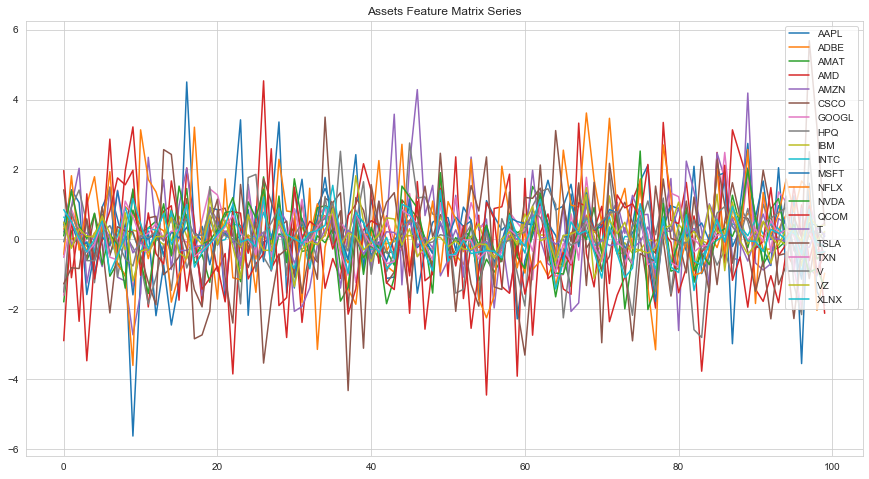

In [171]:
fig,ax=plt.subplots(1)
for i in index:
    df.loc[i,:].plot(ax=ax)
    print(df.loc[i,:].mean())
ax.legend(index)
ax.set_title("Assets Feature Matrix Series")
fig.set_size_inches(15, 8) 

## PCA

In [150]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([ 0.35809654,  0.15941593,  0.12601951,  0.48608336,  0.35658929,
       -0.02479565,  0.14018049,  0.22906618,  0.08095813,  0.10090638,
        0.14091685,  0.45785727,  0.23455743, -0.11373561,  0.00976756,
        0.17505922,  0.1117673 ,  0.13138817,  0.03316707,  0.13611297])

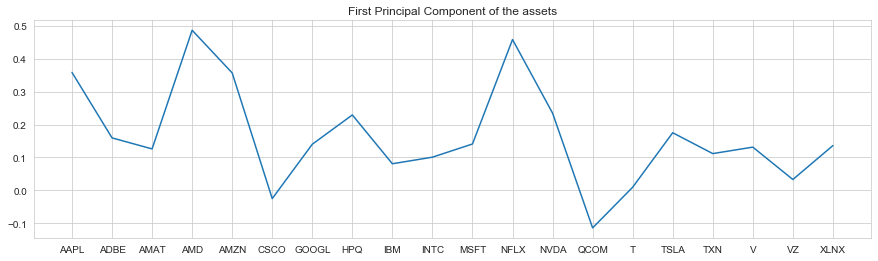

In [151]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets')
fig.set_size_inches(15, 4) 

In [152]:
pc1.sort_values()

QCOM    -0.113736
CSCO    -0.024796
T        0.009768
VZ       0.033167
IBM      0.080958
INTC     0.100906
TXN      0.111767
AMAT     0.126020
V        0.131388
XLNX     0.136113
GOOGL    0.140180
MSFT     0.140917
ADBE     0.159416
TSLA     0.175059
HPQ      0.229066
NVDA     0.234557
AMZN     0.356589
AAPL     0.358097
NFLX     0.457857
AMD      0.486083
dtype: float64

In [153]:
dominant_assets = pc1.sort_values().index[-10:]
dominant_assets = " ".join(dominant_assets)
dominant_assets


'GOOGL MSFT ADBE TSLA HPQ NVDA AMZN AAPL NFLX AMD'

## ICA

In [154]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


[*********************100%***********************]  20 of 20 completed


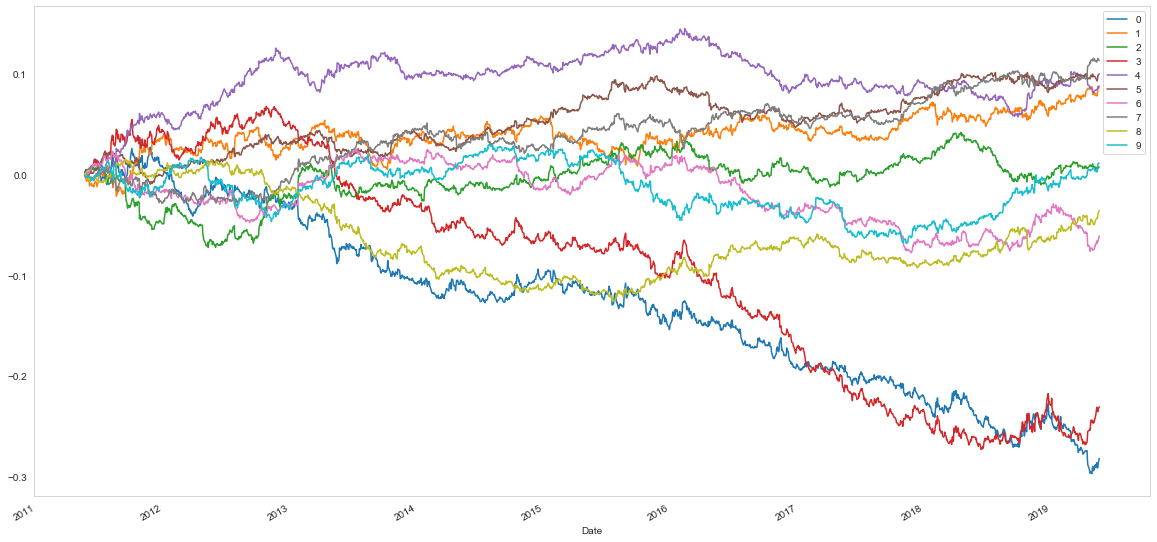

In [155]:
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(ica.components_[i]).cumsum().plot(ax=ax)
ax.legend([str(i) for i in range(10)])
ax.grid()

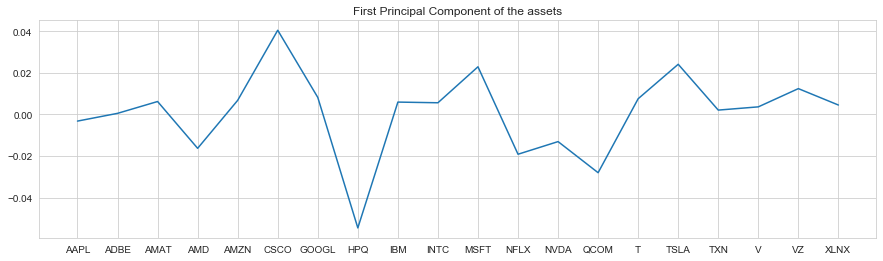

In [158]:
fig, axes = plt.subplots(1)
ic1 = pd.Series(index=index, data=ica.components_[4])
ic1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets')
fig.set_size_inches(15, 4) 

In [159]:
ic1.sort_values()

HPQ     -0.054606
QCOM    -0.028063
NFLX    -0.019187
AMD     -0.016341
NVDA    -0.013108
AAPL    -0.003253
ADBE     0.000474
TXN      0.002035
V        0.003591
XLNX     0.004471
INTC     0.005560
IBM      0.005885
AMAT     0.006163
AMZN     0.006731
T        0.007502
GOOGL    0.008130
VZ       0.012360
MSFT     0.022855
TSLA     0.024063
CSCO     0.040424
dtype: float64

In [160]:
num_assets = len(ica.components_[0])//2
dominant_assets_ica = ic1.sort_values().index[-num_assets:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'INTC IBM AMAT AMZN T GOOGL VZ MSFT TSLA CSCO'

# Testing

## PCA

In [161]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMD      0.024802
            AMZN    -0.000780
            GOOGL    0.008508
                       ...   
2021-05-19  HPQ     -0.016839
            MSFT     0.002471
            NFLX     0.002916
            NVDA     0.003561
            TSLA    -0.025253
Length: 5040, dtype: float64

In [162]:
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
mean_returns

[0.012911459002112125,
 -0.007451942159326608,
 -0.016845064374780394,
 0.0008943841876453806,
 0.0070419240052759235,
 -0.015833016983586877,
 0.001178812224894399,
 -0.019864872956554126,
 -0.02581543699473392,
 0.04384280221221988,
 0.006471474677925216,
 0.019820030802772726,
 0.014959955645889433,
 0.014268153837741248,
 0.0007277893740751829,
 -0.009896571142665378,
 0.003159120115824132,
 -0.00865225464842645,
 0.00701925681023825,
 0.02055700891581047,
 0.008885204124250512,
 0.004211431591737158,
 -0.003799154511114633,
 0.002271491933563041,
 -0.02043696882695869,
 0.012976546234369302,
 0.010357457331938314,
 -0.0013772921639650716,
 0.016725592950135048,
 0.00027458536075779526,
 0.010860375693717205,
 -0.001531745763091097,
 -0.007993235611210592,
 0.006972664307624665,
 0.013339357731905022,
 0.0016879739177265486,
 0.0063954520327274885,
 0.007099773167687573,
 -0.005448937943285159,
 -0.001222291911408524,
 -0.01114943309803591,
 -0.008275463020346142,
 0.00642949538837

In [163]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

CPD+PCA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,50.822%
Cumulative returns,127.474%
Annual volatility,34.028%
Sharpe ratio,1.38
Calmar ratio,1.48
Stability,0.94
Max drawdown,-34.42%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.42,2020-02-19,2020-03-18,2020-06-22,89
1,15.29,2020-09-02,2020-09-23,2020-12-07,69
2,13.66,2021-02-12,2021-03-08,2021-04-13,43
3,10.47,2019-07-15,2019-08-23,2019-10-28,76
4,10.12,2021-04-15,2021-05-12,NaT,NaN


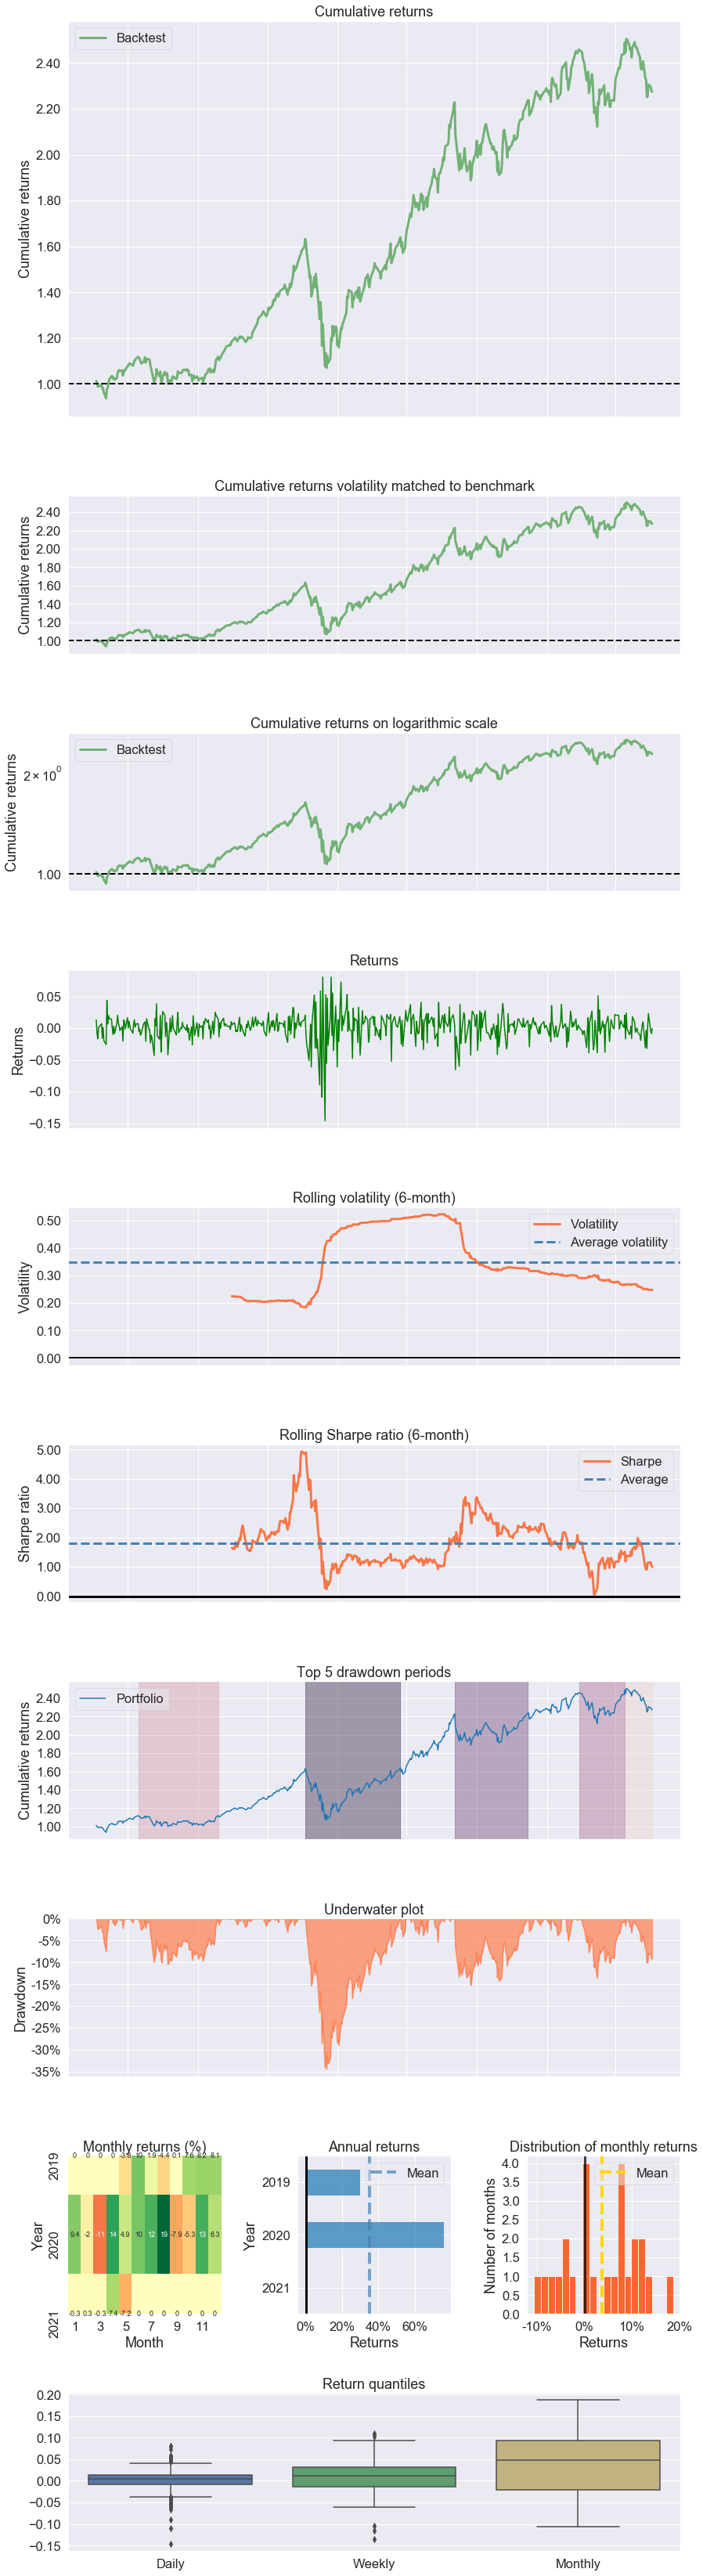

In [164]:
import pyfolio as pf
print("CPD+PCA")
pf.create_returns_tear_sheet(df)

## ICA

In [165]:
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AMAT     0.022545
            AMZN    -0.000780
            CSCO     0.009064
            GOOGL    0.008508
            IBM      0.009795
                       ...   
2021-05-19  INTC     0.009437
            MSFT     0.002471
            T       -0.020168
            TSLA    -0.025253
            VZ      -0.004557
Length: 5040, dtype: float64

In [166]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.008867081458231141,
 -0.0101813599095967,
 -0.009997098392339598,
 -0.0022348678068614624,
 -0.008053183813621922,
 -0.0036127209369356096,
 -4.570119807576489e-05,
 -0.024666951687952875,
 -0.012876791246753071,
 0.028518422212000384,
 0.007107724413213656,
 0.01397963461290761,
 0.01215137452370203,
 0.013140913009558552,
 0.006977408870521807,
 -0.013053313044079706,
 0.0079113276600133,
 -0.00369501940096435,
 0.004305329624529852,
 0.012593009981768554,
 0.0024312276369415466,
 0.004419939145689345,
 0.0018049409306743146,
 0.001263479036674342,
 -0.015173290523762262,
 0.0062979955254265805,
 0.0030449661851407405,
 0.000623164190358283,
 0.008449455518192383,
 0.005114884849722756,
 0.010342542329609516,
 -0.0011229607939597485,
 -0.006117846314690034,
 0.00029459424572131354,
 0.014264932339276105,
 0.0015892323263949405,
 0.012229197441540229,
 0.00566364773271264,
 -0.0058338552838590905,
 -0.002514439233105614,
 0.00903763581491961,
 -0.002814602579597247,
 0.006845273657

In [167]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

CPD+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,30.777%
Cumulative returns,71.027%
Annual volatility,28.778%
Sharpe ratio,1.08
Calmar ratio,0.93
Stability,0.87
Max drawdown,-33.163%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.16,2020-02-19,2020-03-20,2020-07-20,109
1,12.42,2020-09-02,2020-10-28,2020-11-24,60
2,9.69,2019-07-24,2019-08-23,2019-10-24,67
3,6.97,2019-05-21,2019-06-03,2019-06-10,15
4,6.84,2021-02-17,2021-03-04,2021-03-26,28


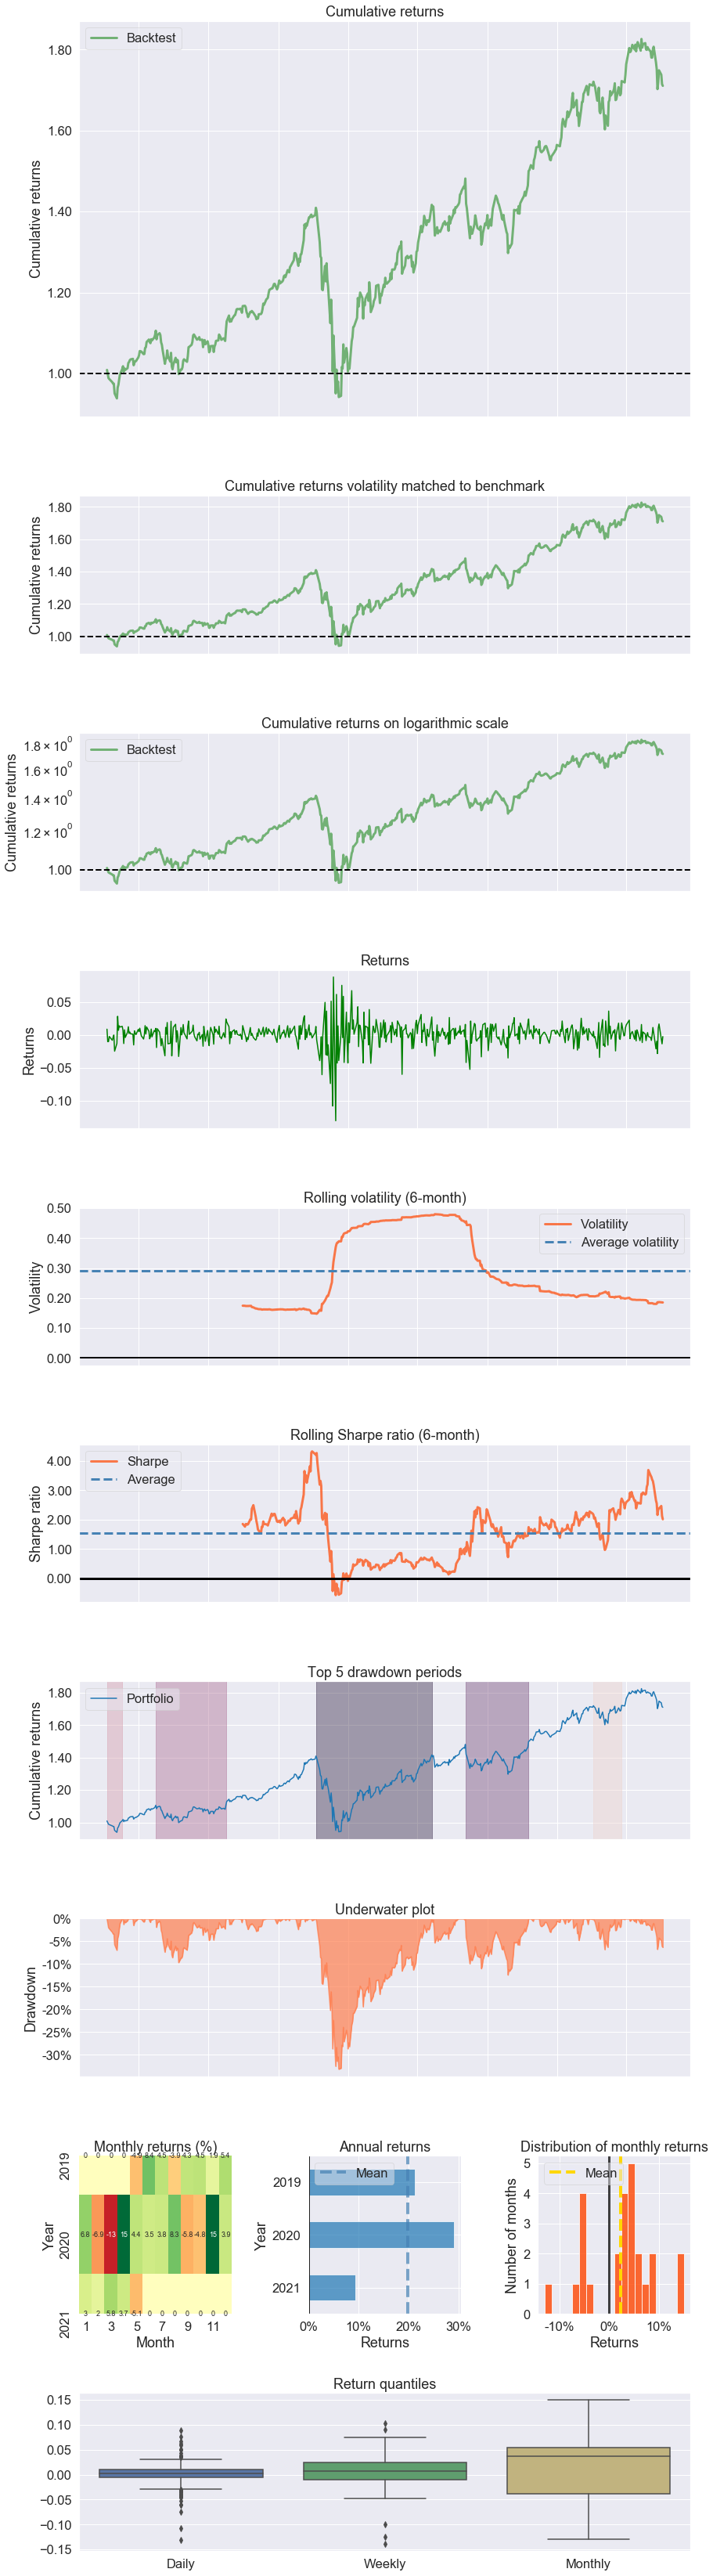

In [168]:
import pyfolio as pf
print("CPD+ICA")
pf.create_returns_tear_sheet(df)